# Garmen PanSiego -- SpamAndFlags 2020
by szabolor from !SpamAndHex

The challenge is about processing a recorded GPS signal to find the position where the recording happened. That location tag can be searched on instagram, where there were recently updated images with the flag on them.

The trick of the current challenge is the length of the GPS signal: 10 seconds is too short to be processed with off-the-shelf tools, so specification reading and implementation is probably necessary.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as spfft
import scipy.signal as spsig
import ipywidgets as widgets

In [2]:
plt.style.use("seaborn-whitegrid")
matplotlib.rcParams['figure.figsize'] = (15, 10)

# Get the ephemeris file
Usually daily broadcast ephemeris data (which is uploaded to GPS SVs and downloaded via NAV messages) are available from ftp://cddis.nasa.gov. As the filename suggested, the boardcast timestamp we are looking for is somewhere between 2020.05.06. 12:00 and 14:00; it can be found in the brdc1270.20n file. Also they are in RINEX format, so let's parse it first.

(Normally a GPS receiver would obtain ephemeris from the NAV messages carried by the GPS signal. But this time the trick is that the RF record is only 10 seconds long, and full ephemeris spans over 3 subframes which is 18 seconds. Thus we can't extract the ephemeris from NAV messages, we must use the ephemeris from cddis!)

In [3]:
class RINEX():
    def __init__(self, data):
        # r: RINEX data input
        self.r = data.split('\n')
        
        # p: Parsed RINEX output
        self.p = {
            "info": {
                "version": "",
                "filetype": "",
                "name": "",
                "agency": "",
                "date": "",
                "comment": "",
            },
            "ion": {
                "alpha": (0.0, 0.0, 0.0, 0.0),
                "beta": (0.0, 0.0, 0.0, 0.0),
            },
            "utc": {
                "a": (0.0, 0.0),
                "tot": 0,
                "wnt": 0,
                "leap_sec": 0,
            },
            "eph": [],
        }


    def parse_header(self, line):
        if "RINEX VERSION / TYPE" in line:
            self.p["info"]["version"] = line[0:9].strip()
            self.p["info"]["filetype"] = line[20]
            assert self.p["info"]["filetype"] == "N", f"Unknown file type of {self.p['info']['filetype']}, want 'N'"
            return "version"
        
        if "PGM / RUN BY / DATE " in line:
            self.p["info"]["name"] = line[0:20].strip()
            self.p["info"]["agency"] = line[20:40].strip()
            self.p["info"]["date"] = line[40:60].strip()
            return "prog"
            
        if "COMMENT             " in line:
            self.p["info"]["comment"] += line[0:60].strip() + "\n"
            return "comment"
        
        if "ION ALPHA           " in line:
            self.p["ion"]["alpha"] = (
                float(line[ 2:14].replace("D", "e")),
                float(line[14:26].replace("D", "e")),
                float(line[26:38].replace("D", "e")),
                float(line[38:50].replace("D", "e")),
            )
            return "alpha"
            
        if "ION BETA            " in line:
            self.p["ion"]["beta"] = (
                float(line[ 2:14].replace("D", "e")),
                float(line[14:26].replace("D", "e")),
                float(line[26:38].replace("D", "e")),
                float(line[38:50].replace("D", "e")),
            )
            return "beta"
            
        if "DELTA-UTC: A0,A1,T,W" in line:
            self.p["utc"]["a"] = (
                float(line[ 3:22].replace("D", "e")),
                float(line[22:41].replace("D", "e")),
            )
            self.p["utc"]["tot"] = int(line[41:50])
            self.p["utc"]["wnt"] = int(line[50:59])
            return "utc"
            
        if "LEAP SECONDS        " in line:
            self.p["utc"]["leap_sec"] = float(line[0:6])
            return "leap"
            
        if "END OF HEADER       " in line:
            return "end"
    
    
    def parse_eph(self, idx):
        eph = {
            "toe": {},
            "toc": {},
        }
        
        line = self.r[idx]
        eph["prn"]   = int(line[0:2])
        eph["toe"]["year"]  = int(line[ 3: 5]) + 2000
        eph["toe"]["month"] = int(line[ 6: 8])
        eph["toe"]["day"]   = int(line[ 9:11])
        eph["toe"]["hour"]  = int(line[12:14])
        eph["toe"]["min"]   = int(line[15:17])
        eph["toe"]["sec"]   = float(line[17:22].replace("D", "e"))
        eph["af"] = (
            float(line[22:41].replace("D", "e")),
            float(line[41:60].replace("D", "e")),
            float(line[60:79].replace("D", "e")),
        )
        
        line = self.r[idx+1]
        eph["crs"]         = float(line[22:41].replace("D", "e"))
        eph["delta_n"]     = float(line[41:60].replace("D", "e"))
        eph["m0"]          = float(line[60:79].replace("D", "e"))
        
        line = self.r[idx+2]
        eph["cuc"]         = float(line[ 3:22].replace("D", "e"))
        eph["ecc"]         = float(line[22:41].replace("D", "e"))
        eph["cus"]         = float(line[41:60].replace("D", "e"))
        eph["sqrt_A"]      = float(line[60:79].replace("D", "e"))
        
        line = self.r[idx+3]
        eph["toc"]["sec"]  = float(line[ 3:22].replace("D", "e"))
        eph["cic"]         = float(line[22:41].replace("D", "e"))
        eph["omega0"]      = float(line[41:60].replace("D", "e"))
        eph["cis"]         = float(line[60:79].replace("D", "e"))
        
        line = self.r[idx+4]
        eph["inc0"]        = float(line[ 3:22].replace("D", "e"))
        eph["crc"]         = float(line[22:41].replace("D", "e"))
        eph["aop"]         = float(line[41:60].replace("D", "e"))
        eph["omega_dot"]   = float(line[60:79].replace("D", "e"))
        
        line = self.r[idx+5]
        eph["inc_dot"]     = float(line[ 3:22].replace("D", "e"))
        eph["toc"]["week"] = float(line[41:60].replace("D", "e"))
        
        line = self.r[idx+6]
        eph["tgd"]         = float(line[41:60].replace("D", "e"))
        eph["iodc"]        = float(line[60:79].replace("D", "e"))
        
        line = self.r[idx+7]
        eph["fitint"]      = float(line[41:60].replace("D", "e"))
        
        self.p["eph"].append(eph)
    
    
    def parse(self):
        i = 0
        while self.parse_header(self.r[i]) != "end":
            i += 1
        
        i += 1
        while i < (len(self.r)-8):
            self.parse_eph(i)
            i += 8
        return self.p

In [4]:
# little cheating: a dummy PRN=7 SV was added as a padding (it's not used in the constellation)
r = RINEX("""     2              NAVIGATION DATA                         RINEX VERSION / TYPE
CCRINEXN V1.6.0 UX  CDDIS               06-MAY-20 09:18     PGM / RUN BY / DATE 
IGS BROADCAST EPHEMERIS FILE                                COMMENT             
    0.8382D-08  0.2235D-07 -0.5960D-07 -0.1192D-06          ION ALPHA           
    0.8602D+05  0.6554D+05 -0.1311D+06 -0.4588D+06          ION BETA            
    0.372529029846D-08 0.621724893790D-14   503808     2104 DELTA-UTC: A0,A1,T,W
    18                                                      LEAP SECONDS        
                                                            END OF HEADER       
 1 20  5  6 12  0  0.0-0.374603085220D-03-0.773070496507D-11 0.000000000000D+00
    0.590000000000D+02 0.301562500000D+02 0.365015204348D-08 0.306797977155D+01
    0.151433050632D-05 0.978651153855D-02 0.132527202368D-04 0.515363296127D+04
    0.302400000000D+06 0.502914190292D-07-0.283381537976D+01-0.186264514923D-08
    0.980223448938D+00 0.133500000000D+03 0.769525293040D+00-0.746209654056D-08
    0.690028742467D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00 0.512227416039D-08 0.590000000000D+02
    0.295220000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
 2 20  5  6 12  0  0.0-0.451381783932D-03-0.625277607469D-11 0.000000000000D+00
    0.980000000000D+02 0.528125000000D+01 0.400766693541D-08-0.297211298700D+01
    0.415369868278D-06 0.197183386190D-01 0.136177986860D-04 0.515369552422D+04
    0.302400000000D+06 0.292435288429D-06-0.290963466557D+01-0.558793544769D-08
    0.959243164374D+00 0.110718750000D+03-0.163196737877D+01-0.742495213620D-08
    0.561809115890D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.280000000000D+01 0.000000000000D+00-0.176951289177D-07 0.980000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
 3 20  5  6 12  0  0.0-0.167116988450D-03-0.118234311230D-10 0.000000000000D+00
    0.710000000000D+02 0.125000000000D+02 0.496270671665D-08 0.202374720517D+01
    0.692903995514D-06 0.278828537557D-02 0.386312603950D-05 0.515355105019D+04
    0.302400000000D+06-0.838190317154D-07-0.179329743157D+01-0.279396772385D-07
    0.965067957034D+00 0.304375000000D+03 0.695446405757D+00-0.842749389609D-08
    0.262153776900D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00 0.186264514923D-08 0.710000000000D+02
    0.295872000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
 4 20  5  6 12  0  0.0-0.857124105096D-04-0.500222085975D-11 0.000000000000D+00
    0.196000000000D+03-0.446562500000D+02 0.457626204825D-08-0.211416122444D+01
   -0.258721411228D-05 0.715826288797D-03 0.112764537334D-04 0.515369222641D+04
    0.302400000000D+06 0.115483999252D-06-0.714048509249D+00 0.931322574616D-08
    0.960010734083D+00 0.161343750000D+03-0.259590712607D+01-0.803247744207D-08
   -0.582524264474D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.419095158577D-08 0.708000000000D+03
    0.300888000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
 5 20  5  6 12  0  0.0-0.121593475342D-04-0.682121026330D-12 0.000000000000D+00
    0.870000000000D+02 0.210000000000D+02 0.527486257634D-08-0.292603139958D+00
    0.125914812088D-05 0.584133400116D-02 0.404193997383D-05 0.515364082146D+04
    0.302400000000D+06 0.745058059692D-08-0.182491117465D+01 0.707805156708D-07
    0.951984407709D+00 0.296500000000D+03 0.789619690007D+00-0.864500295622D-08
    0.321441960777D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.111758708954D-07 0.870000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
 6 20  5  6 12  0  0.0-0.266485381871D-03-0.704858393874D-11 0.000000000000D+00
    0.650000000000D+02 0.117187500000D+02 0.373229832235D-08-0.308181360181D+01
    0.694766640663D-06 0.196644745302D-02 0.134017318487D-04 0.515353887558D+04
    0.302400000000D+06 0.558793544769D-07-0.284205266331D+01-0.242143869400D-07
    0.979792698562D+00 0.132718750000D+03-0.106871473157D+01-0.757174396496D-08
    0.587167315018D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00 0.419095158577D-08 0.650000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
 7 20  5  6 12  0  0.0-0.266485381871D-03-0.704858393874D-11 0.000000000000D+00
    0.650000000000D+02 0.117187500000D+02 0.373229832235D-08-0.308181360181D+01
    0.694766640663D-06 0.196644745302D-02 0.134017318487D-04 0.515353887558D+04
    0.302400000000D+06 0.558793544769D-07-0.284205266331D+01-0.242143869400D-07
    0.979792698562D+00 0.132718750000D+03-0.106871473157D+01-0.757174396496D-08
    0.587167315018D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00 0.419095158577D-08 0.650000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
 8 20  5  6 12  0  0.0-0.330475158989D-04-0.125055521494D-11 0.000000000000D+00
    0.680000000000D+02-0.127031250000D+03 0.418267422517D-08-0.941782438345D+00
   -0.664219260216D-05 0.534600601532D-02 0.870972871780D-05 0.515366341972D+04
    0.302400000000D+06 0.260770320892D-07 0.238022535540D+01-0.949949026108D-07
    0.969752669840D+00 0.217843750000D+03-0.846992058676D-01-0.802926302246D-08
   -0.523593238331D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00 0.512227416039D-08 0.680000000000D+02
    0.301188000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
 9 20  5  6 12  0  0.0-0.211971346289D-03-0.738964445190D-11 0.000000000000D+00
    0.840000000000D+02-0.485312500000D+02 0.481234331056D-08-0.733180787420D+00
   -0.271946191788D-05 0.153714371845D-02 0.110790133476D-04 0.515374232674D+04
    0.302400000000D+06 0.409781932831D-07-0.761789158410D+00-0.353902578354D-07
    0.952680041348D+00 0.165781250000D+03 0.180549090935D+01-0.817676916668D-08
   -0.630026243122D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00 0.139698386192D-08 0.840000000000D+02
    0.296457000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
10 20  5  6 12  0  0.0-0.332545023412D-03-0.117097442853D-10 0.000000000000D+00
    0.100000000000D+03 0.156250000000D+02 0.495877798158D-08 0.951203118754D+00
    0.769272446632D-06 0.556479312945D-02 0.398419797421D-05 0.515365720177D+04
    0.302400000000D+06-0.186264514923D-07-0.179634799466D+01 0.726431608200D-07
    0.965021847319D+00 0.305156250000D+03-0.263036217058D+01-0.844963767561D-08
    0.178221709364D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00 0.232830643654D-08 0.100000000000D+03
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
11 20  5  6 12  0  0.0-0.285058747977D-03 0.106865627458D-10 0.000000000000D+00
    0.104000000000D+03-0.615937500000D+02 0.493877714846D-08 0.255561816760D+01
   -0.302866101265D-05 0.159141670447D-01 0.137779861689D-04 0.515372434235D+04
    0.302400000000D+06 0.124797224999D-06 0.297648496741D+01 0.111758708954D-06
    0.912935453712D+00 0.845000000000D+02 0.197945698874D+01-0.795283126734D-08
   -0.382158775590D-10 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.282842707634D+01 0.000000000000D+00-0.125728547573D-07 0.104000000000D+03
    0.295223000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
12 20  5  6 12  0  0.0 0.121090095490D-03-0.432009983342D-11 0.000000000000D+00
    0.750000000000D+02 0.219375000000D+02 0.466340853540D-08 0.161989206234D+01
    0.806525349617D-06 0.811392010655D-02 0.128895044327D-05 0.515369386482D+04
    0.302400000000D+06-0.158324837685D-06 0.141792773950D+01-0.707805156708D-07
    0.978254105193D+00 0.364531250000D+03 0.114560484562D+01-0.847678166341D-08
   -0.525021869268D-10 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.121071934700D-07 0.750000000000D+02
    0.295902000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
13 20  5  6 12  0  0.0 0.779842957854D-05 0.306954461848D-11 0.000000000000D+00
    0.850000000000D+02-0.461875000000D+02 0.432339437244D-08-0.183417657654D+01
   -0.238977372646D-05 0.411260232795D-02 0.120066106319D-04 0.515366411781D+04
    0.302400000000D+06 0.856816768646D-07-0.619260100132D+00-0.651925802231D-07
    0.967981430072D+00 0.149500000000D+03 0.109426064302D+01-0.783889795014D-08
   -0.570380901511D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.111758708954D-07 0.850000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
14 20  5  6 12  0  0.0-0.148494727910D-04 0.261479726760D-11 0.000000000000D+00
    0.630000000000D+02-0.359687500000D+02 0.455554689967D-08-0.131782015147D+01
   -0.165030360222D-05 0.113763801055D-01 0.109300017357D-04 0.515364329719D+04
    0.302400000000D+06 0.894069671631D-07-0.666073557666D+00 0.312924385071D-06
    0.960531326648D+00 0.168031250000D+03-0.191858189241D+01-0.797533220460D-08
   -0.512878506306D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.977888703346D-08 0.630000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
15 20  5  6 12  0  0.0-0.233093742281D-03 0.261479726760D-11 0.000000000000D+00
    0.310000000000D+02-0.720312500000D+02 0.539808199464D-08-0.192879862115D+01
   -0.390782952309D-05 0.122534073889D-01 0.861473381519D-05 0.515367619324D+04
    0.302400000000D+06 0.145286321640D-06-0.850729293570D+00-0.150874257088D-06
    0.928132676817D+00 0.188531250000D+03 0.874765833440D+00-0.834641909043D-08
   -0.469662420468D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.107102096081D-07 0.310000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
16 20  5  6 12  0  0.0-0.154939480126D-03-0.443378667114D-11 0.000000000000D+00
    0.480000000000D+02 0.137500000000D+01 0.473376860903D-08-0.215274609840D+00
    0.165775418282D-06 0.115212901728D-01 0.101141631603D-05 0.515374954796D+04
    0.302400000000D+06 0.540167093277D-07 0.143680291421D+01 0.875443220139D-07
    0.978483974974D+00 0.365437500000D+03 0.630125221965D+00-0.867714715229D-08
   -0.134291308058D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.107102096081D-07 0.480000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
17 20  5  6 12  0  0.0 0.260332133621D-03 0.613908923697D-11 0.000000000000D+00
    0.860000000000D+02-0.136875000000D+03 0.396695095372D-08-0.116552733070D+01
   -0.701844692230D-05 0.132088109385D-01 0.101234763861D-04 0.515369668198D+04
    0.302400000000D+06-0.968575477600D-07 0.245260466103D+01 0.255182385445D-06
    0.984074007318D+00 0.197968750000D+03-0.164373628115D+01-0.805104964425D-08
   -0.566809324169D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.107102096081D-07 0.860000000000D+02
    0.295226000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
18 20  5  6 12  0  0.0 0.180756673217D-03 0.125055521494D-10 0.000000000000D+00
    0.210000000000D+03 0.236250000000D+02 0.414302971667D-08-0.291870657168D+01
    0.132061541081D-05 0.613045645878D-03 0.118575990200D-04 0.515434860992D+04
    0.302400000000D+06-0.186264514923D-08-0.281628257869D+01-0.484287738800D-07
    0.963786929411D+00 0.152500000000D+03 0.288532003083D+01-0.782139722116D-08
    0.572881005651D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.791624188423D-08 0.722000000000D+03
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
19 20  5  6 12  0  0.0-0.162479467690D-03 0.511590769747D-11 0.000000000000D+00
    0.330000000000D+02-0.146531250000D+03 0.383694553847D-08 0.150483092947D+01
   -0.792928040028D-05 0.940195098519D-02 0.102296471596D-04 0.515369148254D+04
    0.302400000000D+06 0.726431608200D-07 0.249826462668D+01-0.225380063057D-06
    0.982277802853D+00 0.197156250000D+03 0.160484390035D+01-0.788354266691D-08
   -0.572166690182D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.153668224812D-07 0.330000000000D+02
    0.296566000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
20 20  5  6 12  0  0.0 0.527733005583D-03 0.000000000000D+00 0.000000000000D+00
    0.250000000000D+02 0.338437500000D+02 0.561594821250D-08 0.251422437535D+01
    0.172294676304D-05 0.508313579485D-02 0.383332371712D-05 0.515363662529D+04
    0.302400000000D+06 0.130385160446D-07-0.192655198860D+01 0.154599547386D-06
    0.933416710587D+00 0.287437500000D+03 0.265347487622D+01-0.872572060415D-08
    0.376087094109D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.884756445885D-08 0.250000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
21 20  5  6 12  0  0.0-0.497465953231D-05 0.488853402203D-11 0.000000000000D+00
    0.610000000000D+02-0.162500000000D+01 0.439589739249D-08 0.125466941292D+01
   -0.417232513428D-06 0.246343892068D-01 0.120215117931D-04 0.515352034950D+04
    0.302400000000D+06 0.540167093277D-07-0.290735157710D+01-0.674277544022D-06
    0.953185352270D+00 0.145906250000D+03-0.133307531491D+01-0.807069331963D-08
    0.493591988659D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.102445483208D-07 0.610000000000D+02
    0.300048000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
22 20  5  6 12  0  0.0-0.783132854849D-03 0.113686837722D-11 0.000000000000D+00
    0.580000000000D+02 0.269062500000D+02 0.571416658940D-08-0.195691028318D+01
    0.169686973095D-05 0.721247284673D-02 0.365078449249D-05 0.515349938393D+04
    0.302400000000D+06-0.149011611938D-07-0.187900872073D+01 0.130385160446D-06
    0.930087919495D+00 0.292218750000D+03-0.117179125040D+01-0.878572310349D-08
    0.375015620906D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.181607902050D-07 0.580000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
23 20  5  6 12  0  0.0-0.116419512778D-03 0.306954461848D-11 0.000000000000D+00
    0.440000000000D+02-0.556250000000D+02 0.494270588354D-08-0.296478709995D+01
   -0.317022204399D-05 0.141984791262D-01 0.110492110252D-04 0.515516026115D+04
    0.302400000000D+06 0.182539224625D-06-0.770145148985D+00-0.270083546638D-06
    0.943488853286D+00 0.156750000000D+03-0.219421714588D+01-0.804104922769D-08
   -0.621454457501D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.630000000000D+02-0.204890966415D-07 0.440000000000D+02
    0.295707000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
24 20  5  6 12  0  0.0-0.126650556922D-04-0.454747350886D-12 0.000000000000D+00
    0.290000000000D+02 0.104250000000D+03 0.487234580990D-08-0.300995488143D+01
    0.527687370777D-05 0.964139925782D-02 0.120494514704D-04 0.515366231537D+04
    0.302400000000D+06-0.614672899246D-07 0.240192916268D+00-0.210478901863D-06
    0.937071040450D+00 0.133312500000D+03 0.666661946243D+00-0.804497796277D-08
    0.217866217860D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.280000000000D+01 0.000000000000D+00 0.279396772385D-08 0.290000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
25 20  5  6 12  0  0.0 0.192597508431D-05 0.295585778076D-11 0.000000000000D+00
    0.420000000000D+02 0.368125000000D+02 0.498163607657D-08 0.141267493318D+01
    0.179000198841D-05 0.927090924233D-02 0.123679637909D-05 0.515355062103D+04
    0.302400000000D+06-0.189989805222D-06 0.134920409353D+01 0.113621354103D-06
    0.965621339445D+00 0.360312500000D+03 0.929205443422D+00-0.870786271744D-08
    0.500020827875D-11 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00 0.558793544769D-08 0.420000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
26 20  5  6 12  0  0.0 0.201210379600D-03 0.727595761418D-11 0.000000000000D+00
    0.550000000000D+02 0.359687500000D+02 0.539665336370D-08 0.740271039329D+00
    0.201538205147D-05 0.474308512639D-02 0.430271029472D-06 0.515360862732D+04
    0.302400000000D+06 0.596046447754D-07 0.131427229571D+01 0.130385160446D-07
    0.946740493005D+00 0.358468750000D+03 0.229013610833D+00-0.890572810218D-08
   -0.528593446610D-10 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00 0.698491930962D-08 0.550000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
27 20  5  6 12  0  0.0-0.286321155727D-03-0.102318153950D-10 0.000000000000D+00
    0.390000000000D+02-0.116031250000D+03 0.403302513454D-08-0.110073802735D+01
   -0.614114105701D-05 0.826771510765D-02 0.895932316780D-05 0.515366256523D+04
    0.302400000000D+06 0.216066837311D-06 0.239434589567D+01 0.558793544769D-08
    0.978181703914D+00 0.215843750000D+03 0.553841427478D+00-0.791068665471D-08
   -0.544308386915D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00 0.186264514923D-08 0.390000000000D+02
    0.296886000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
28 20  5  6 12  0  0.0 0.719695352018D-03-0.306954461848D-11 0.000000000000D+00
    0.280000000000D+02 0.756250000000D+01 0.483698719422D-08-0.351566740715D+00
    0.484287738800D-06 0.184476759750D-01 0.123865902424D-05 0.515365990067D+04
    0.302400000000D+06-0.257045030594D-06 0.144055299937D+01 0.745058059692D-08
    0.977500497574D+00 0.366375000000D+03-0.140809506040D+01-0.894144387560D-08
   -0.285726187357D-11 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.280000000000D+01 0.000000000000D+00-0.111758708954D-07 0.280000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
29 20  5  6 12  0  0.0-0.979364849627D-04-0.898126018001D-11 0.000000000000D+00
    0.480000000000D+02-0.125937500000D+03 0.379908681864D-08-0.695721639165D+00
   -0.658072531223D-05 0.142107368447D-02 0.932253897190D-05 0.515359208489D+04
    0.302400000000D+06-0.707805156708D-07 0.246432261437D+01 0.465661287308D-07
    0.985734223307D+00 0.213375000000D+03 0.189515212268D+01-0.778353850134D-08
   -0.438232539859D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00-0.977888703346D-08 0.480000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
30 20  5  6 12  0  0.0-0.214138068259D-03-0.829913915368D-11 0.000000000000D+00
    0.890000000000D+02 0.138406250000D+03 0.499056501992D-08 0.228164837174D+01
    0.722333788872D-05 0.454434962012D-02 0.116471201181D-04 0.515366278267D+04
    0.302400000000D+06-0.782310962677D-07 0.334925990509D+00 0.763684511185D-07
    0.939096677283D+00 0.145218750000D+03-0.288630831830D+01-0.830106005818D-08
    0.347157317639D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.200000000000D+01 0.000000000000D+00 0.372529029846D-08 0.890000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00
31 20  5  6 12  0  0.0-0.406140461564D-04-0.238742359215D-11 0.000000000000D+00
    0.950000000000D+02 0.118500000000D+03 0.453233164695D-08 0.193228713072D+01
    0.639446079731D-05 0.953020830639D-02 0.111274421215D-04 0.515357779884D+04
    0.302400000000D+06-0.949949026108D-07 0.327416360949D+00 0.230967998505D-06
    0.958214627634D+00 0.165218750000D+03 0.128932327532D+00-0.807533637017D-08
    0.182864759908D-09 0.100000000000D+01 0.210400000000D+04 0.000000000000D+00
    0.280000000000D+01 0.000000000000D+00-0.130385160446D-07 0.950000000000D+02
    0.295218000000D+06 0.400000000000D+01 0.000000000000D+00 0.000000000000D+00

""")
eph = r.parse()["eph"]
print(eph[1])

{'toe': {'year': 2020, 'month': 5, 'day': 6, 'hour': 12, 'min': 0, 'sec': 0.0}, 'toc': {'sec': 302400.0, 'week': 2104.0}, 'prn': 2, 'af': (-0.000451381783932, -6.25277607469e-12, 0.0), 'crs': 5.28125, 'delta_n': 4.00766693541e-09, 'm0': -2.972112987, 'cuc': 4.15369868278e-07, 'ecc': 0.019718338619, 'cus': 1.3617798686e-05, 'sqrt_A': 5153.69552422, 'cic': 2.92435288429e-07, 'omega0': -2.90963466557, 'cis': -5.58793544769e-09, 'inc0': 0.959243164374, 'crc': 110.71875, 'aop': -1.63196737877, 'omega_dot': -7.4249521362e-09, 'inc_dot': 5.6180911589e-10, 'tgd': -1.76951289177e-08, 'iodc': 98.0, 'fitint': 0.0}


# Orbital math
Then read from the specification (https://www.gps.gov/technical/icwg/IS-GPS-200H.pdf) and some good blogpost (http://www.telesens.co/2017/07/17/calculating-position-from-raw-gps-data) on the topic. Also a very good (and quite old!) tools can be found e.g. here: https://www.ngs.noaa.gov/gps-toolbox/bc_velo.htm . Basically the most difficult SV position calculation algorithms are present in the form of equations in the specification, also "bc_velo" present a C-implementation as well. Furthermore ionospherical corrections can be ommited, because it contributes so tiny values to the whole.

Based on the information above, we can implement the SV position computation at a given time respect to the ephemeris time. Also write some tools for LLA (latitude, longitude, altitude) to xyz (Earth-Centered Earth-Fixed Carthesian coordinates).

In [5]:
class SV():    
    def __init__(self, eph):
        # Ephemeris
        self.e = eph
        # Containts
        self.c = {
            "WGS84_GM":     3.986005e14,
            "WGS84_sqrtGM": 19964981.843217388,
            "WGS84_Omega":  7.2921151467e-5,
            "WGS84_C":      299792458.0,
            "WGS84_A":      6378137.0,
            "WGS84_B2oA2":  0.9933056200098587,
            "WGS84_E2":     0.00669437999014133,
            "WGS84_A2E4":   1823091254.6094687,
            "WGS84_A2E6o2": 142.9172228982749,
            "WGS84_A2E4t5o2": 4557728136.523672,
            "WGS84_AE2":    42697.672707180056,
            "WGS84_A2E4pA2E6o2": 1823091397.5266917,
            "GPS_F":        -4.442807633e-10,
        }
    
    def position_at_delta_t(self, tk):
        e, c = self.e, self.c
        
        A = e["sqrt_A"] * e["sqrt_A"] # Semi-major axis
        n = c["WGS84_sqrtGM"]/(A*e["sqrt_A"]) + e["delta_n"] # Corrected mean motion
        mk = e["m0"] + n*tk # Mean anomaly
        mkdot = n #  Rate of change of mean anomaly

        # Eccentric Anomaly (iterative solution) and rate of change
        ek = mk                         
        ek = mk + e["ecc"]*np.sin(ek)
        ek = mk + e["ecc"]*np.sin(ek)
        ek = mk + e["ecc"]*np.sin(ek)
        ek = mk + e["ecc"]*np.sin(ek)
        ek = mk + e["ecc"]*np.sin(ek)
        ek = mk + e["ecc"]*np.sin(ek)
        ek = mk + e["ecc"]*np.sin(ek)
        sek = np.sin(ek)
        cek = np.cos(ek)
        omece = (1.0 - e["ecc"]*cek)
        ekdot = mkdot / omece

        # True Anomaly and rate of change
        some2 = np.sqrt(1.0 - e["ecc"]*e["ecc"]) # Square root of One Minus E^2
        tak = np.arctan2(some2*sek, cek-e["ecc"])
        takdot = sek * ekdot * (1.0 + e["ecc"]*np.cos(tak)) / (np.sin(tak) * (1.0 - e["ecc"]*cek))

        # Argument of Latitude
        phik = tak + e["aop"]
        s2phik = np.sin(2.0 * phik)
        c2phik = np.cos(2.0 * phik)

        # Corrected Argument of Latitude and rate of change
        corr_u = e["cus"]*s2phik + e["cuc"]*c2phik # Argument of Latitude Correction
        uk = phik + corr_u
        suk = np.sin(uk)
        s2uk = np.sin(2.0 * uk)
        cuk = np.cos(uk)
        c2uk = np.cos(2.0 * uk)
        ukdot = takdot + 2.0*(e["cus"]*c2uk-e["cuc"]*s2uk)*takdot

        # Corrected Radius and rate of change
        corr_r = e["crs"]*s2phik + e["crc"]*c2phik # Radius Correction
        rk = A*omece + corr_r
        rkdot = A*e["ecc"]*sek*n/omece + 2.0*(e["crs"]*c2uk-e["crc"]*s2uk)*takdot

        # Corrected Inclination and rate of change
        corr_i = e["cis"]*s2phik + e["cic"]*c2phik # Inclination Correction
        ik = e["inc0"] + e["inc_dot"]*tk + corr_i
        ikdot = e["inc_dot"] + (e["cis"]*c2uk-e["cic"]*s2uk)*2.0*takdot
        sik = np.sin(ik)
        cik = np.cos(ik)

        # Positions in orbital plane and rate of change
        xpk = rk * cuk
        ypk = rk * suk
        xpkdot = rkdot*cuk - ypk*ukdot
        ypkdot = rkdot*suk + xpk*ukdot

        # Corrected longitude of ascending node and rate of change
        omegakdot = e["omega_dot"] - c["WGS84_Omega"]
        omegak = e["omega0"] + omegakdot*tk - c["WGS84_Omega"]*e["toc"]["sec"]
        somegak = np.sin(omegak)
        comegak = np.cos(omegak)

        # Earth-fixed Position
        x = xpk*comegak - ypk*somegak*cik
        y = xpk*somegak + ypk*comegak*cik
        z = ypk * sik
        
        # Relativistic timing effects (IS-200H p.101)
        tkrel = c["GPS_F"] * e["ecc"] * e["sqrt_A"] * sek
        tcorr = e["af"][0] + e["af"][1]*tk + e["af"][2]*tk*tk + tkrel - e["tgd"]
        
        return (x, y, z), tcorr
    
    def xyz_to_lla(self, x, y, z):
        # "Converting earth-Centered, Earth-Fixed Coordinates to Geodetic Coordinates"
        # by DONALD K. OLSON (1994)
        # Convert ECEF xyz coordinate to LLA
        zp = np.absolute(z)
        w2 = x*x + y*y
        w = np.sqrt(w2)
        r2 = w2 + z*z
        r = np.sqrt(r2)
        assert r > 100000.0

        lon = np.arctan2(y, x)

        s2 = z * z / r2
        c2 = w2 / r2
        u = self.c["WGS84_A2E4"] / r
        v = self.c["WGS84_A2E6o2"] - self.c["WGS84_A2E4t5o2"]/r

        if c2 > 0.3:
            s = (zp / r) * (1.0 + c2*(self.c["WGS84_AE2"]+u+s2*v)/r)
            lat = np.arcsin(s)
            ss = s * s
            c = np.sqrt(1.0 - ss)
        else:
            c = (w / r) * (1.0 - s2*(self.c["WGS84_A2E4pA2E6o2"]-u-c2*v)/r)
            lat = np.Acos(c)
            ss = 1.0 - c*c
            s = np.sqrt(ss)

        g = 1.0 - self.c["WGS84_E2"]*ss
        rg = self.c["WGS84_A"] / np.sqrt(g)
        rf = self.c["WGS84_B2oA2"] * rg
        u = w - rg*c
        v = zp - rf*s
        f = c*u + s*v
        m = c*v - s*u
        p = m / (rf/g + f)
        lat = lat + p

        alt = f + m*p/2.0
        if z < 0.0:
            lat = -lat
        
        return (lat, lon, alt)

    def lla_to_xyz(self, lat, lon, alt):
        # https://microem.ru/files/2012/08/GPS.G1-X-00006.pdf
        slat = np.sin(lat)
        clat = np.cos(lat)
        N = self.c["WGS84_A"] / np.sqrt(1.0-self.c["WGS84_E2"]*slat*slat)
        x = (N + alt) * clat * np.cos(lon)
        y = (N + alt) * clat * np.sin(lon)
        z = (self.c["WGS84_B2oA2"]*N + alt) * slat
        return (x,y,z)
    
    def xyz_distance(self, a, b):
        return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2)
    
    def tx_to_rx_frame(self, xyz, tau):
        # Account for the Earth rotation during the signal time-of-flight
        theta = self.c["WGS84_Omega"] * tau
        cot = np.cos(theta)
        sot = np.sin(theta)
        x = cot*xyz[0] + sot*xyz[1]
        y = -sot*xyz[0] + cot*xyz[1]
        z = xyz[2]
        return (x,y,z)

# Signal Acquisition
This is the actual signal processing part of the challenge. We have to correlate the GPS signal in order to get the delays caused by time-of-flight from the SV to the observer.

Also because of the 10-second durration conventional acquisition method (like those built into GPS receivers, which are built for real-world scenarios) won't work, as those tend to use longer filtering. But this time the huge SNR (this is a synthetically generated signal, not an actual record) definitely helps us to implement a very simple one-shot SV signal delay estimation algorithm.

In [6]:
class Acquisition():
    def __init__(self, input_data, fs):
        # convert the signal into numpy complex format
        self.data = np.empty(input_data.shape[0]//2, dtype=np.complex64)
        self.data.real = input_data[0::2]
        self.data.imag = input_data[1::2]
        self.fs = fs
        self.data_t = np.arange(0, len(input_data)/fs, 1/fs)
        
    def gen_code(self, sv_idx):
        # Some valuable code for Gold-code and PRN generation taken from https://github.com/psas/gps
        from collections import deque
        g1tap = (2, 9)
        g2tap = (1, 2, 5, 7, 8, 9)

        sv = [ (1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8),
               (2, 9), (1, 2), (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9),
               (0, 3), (1, 4), (2, 5), (3, 6), (4, 7), (5, 8), (0, 2), (3, 5),
               (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6), (2, 7), (3, 8),
               (4, 9), (3, 9), (0, 6), (1, 7), (3, 9) ]
        
        prn = sv[sv_idx-1]
        g1 = deque(1 for i in range(10))
        g2 = deque(1 for i in range(10))
        g = []

        for i in range(1023):
            val = (g1[9] + g2[prn[0]] + g2[prn[1]]) % 2
            g.append(val)
            g1[9] = sum([g1[i] for i in g1tap]) % 2 
            g1.rotate()
            g2[9] = sum([g2[i] for i in g2tap]) % 2 
            g2.rotate()

        for n, i in enumerate(g):
            if i == 0:
                g[n] = -1
        
        # also scale with the current (non-standard, but practical) sampling frequency
        t = np.arange(0, 1023, 1.023e6/self.fs)
        idx = np.floor(t).astype(int)
        return np.array(g)[idx]
    
    def correlate(self, sv_idx, freq):
        # Correlate with the local generated chirp to de-spread the SV signal
        code = self.gen_code(sv_idx)
        shifted_data = self.data*np.exp(-1j*2*np.pi*freq*self.data_t[:len(self.data)])
        self.corr = spsig.fftconvolve(shifted_data, code[::-1], 'valid')
        return self.corr
    
    def plot_correlate(self, limit=0.010):
        plt.plot(np.absolute(self.corr[:int(self.fs*limit)]), 'x-')
        plt.plot(spsig.fftconvolve(np.absolute(self.corr[:int(self.fs*limit)]), np.ones(200), 'same')/200 * 7)
        #plt.plot(np.absolute(self.corr)*np.angle(self.corr), '.', alpha=0.5)
        #plt.plot(np.angle(self.corr)*100000, 'x-')
        #plt.xlim(1500, 1700)
    
    def get_code_phase(self):
        # Code phase scaled to [0,1)
        return 1 - (np.argmax(np.absolute(self.corr[:int(self.fs/1000)])) / (self.fs/1000))
    
    def find_peaks(self, threshold_n=200, multiplier=6):
        # Moving average thresholding to dinamically find peaks
        threshold = spsig.fftconvolve(np.absolute(self.corr), np.ones(threshold_n), 'same') / threshold_n * multiplier
        peak_idx = np.where(np.absolute(self.corr) >= threshold)[0]
        self.peak_groups = np.split(peak_idx, np.where(np.diff(peak_idx) > 5)[0]+1)
        self.peaks = np.array([np.sum(self.corr[idx]) for idx in self.peak_groups])
    
    def plot_peaks(self):
        plt.plot(np.angle(self.peaks))
    
    def plot_intervals(self):
        plt.plot(np.diff([np.mean(i) for i in self.peak_groups]), '.')
    
    def demodulate(self, plot=False):
        # Get the NAV bits (50bps - 20 chirp/bit)
        # The problem is that the SVs are moving, so there's a considerable Doppler-shift
        # on the signal, so the BPSK constellation will slowly rotate as well!
        # So this function tires to follow the shift by unwrapping the phase -- very rudamentary, but works
        raw_phases = np.angle(self.peaks)/np.pi
        self.phases = []
        baseline = []
        n = 10
        memory = raw_phases[:n]%1 # moving average of bit phases
        for curr in raw_phases:
            curr_frac = curr%1
            if np.absolute((sum(memory)/n - curr_frac)) > 0.5:
                #print(curr, sum(memory)/n)
                curr_frac += np.round(sum(memory)/n-curr_frac)
            memory = np.roll(memory, -1)
            memory[-1] = curr_frac
            baseline.append(sum(memory)/n)
            self.phases.append(int((np.round(curr_frac-curr)%2)))
        if plot:
            plt.plot(baseline, "-", label="filtered baseline")
            plt.plot(raw_phases, ".-", label="raw phases")
            plt.plot(self.phases, ".", label="restored")
            plt.legend()
            #plt.xlim(0, 50)
            #plt.ylim(-0.1, 1.1)
    
    def get_bits(self):
        # "Demodulate" the bits, there are 20 chips during a single bit
        # The initial phase is unknown (thus 0<->1 are ambiguous), so consider that later on.
        bit_run_len = np.diff(np.where(np.diff(self.phases) != 0)[0])/20
        bits = [1]
        for i in bit_run_len:
            tmp = 1^bits[-1]
            bits += [tmp] * int(i)
        self.bit_str = ''.join(map(str, bits))
        return self.bit_str
    
    def find_first_words(self, p=False):
        # This is the bits every subframe must start with (in the beginning of ).
        preamble = "10001011"
        res = []
        bit_str = self.bit_str
        
        i = bit_str.find(preamble)
        while i >= 0 and i < len(self.bit_str):
            if p: print(i, bit_str[i:i+60])
            # also check for the last two zero bits of HOW
            if bit_str[ i+30+28 : i+30+30 ] == "00":
                res.append({
                    # counting the first bit as well, which is not necessary a full bit!
                    "bit_offset": i, 
                    "subframe_id": int(bit_str[ i+30+19 : i+30+22 ], 2),
                    "tow": int(bit_str[ i+30 : i+30+17 ], 2) * 6 - 6 })
            i = bit_str.find(preamble, i+1)
        
        # flip the bits
        bit_str = "".join(map(lambda x: {"1":"0", "0":"1"}[x], bit_str))
        i = bit_str.find(preamble)
        while i >= 0 and i < len(self.bit_str):
            if p: print(i, bit_str[i:i+60])
            if bit_str[ i+30+28 : i+30+30 ] == "00":
                res.append({
                    # counting the first bit as well, which is not necessary a full bit!
                    "bit_offset": i, 
                    "subframe_id": int(bit_str[ i+30+19 : i+30+22 ], 2),
                    "tow": int(bit_str[ i+30 : i+30+17 ], 2) * 6 - 6 }) # HOW: the *next* subframe timestamp!!!
            i = bit_str.find(preamble, i+1)
        return res
    
    def get_sec(self):
        # THE most important function: get the actual transmit times for the beginning of the signal stream
        # Substract the 
        tows = []
        for tmp in self.find_first_words():
            tow = tmp["tow"]
            tow -= (1-self.get_code_phase()) * 1e-3
            leading_code = np.where(np.diff(self.phases) != 0)[0][0]+1
            print(leading_code)
            tow -= leading_code*1e-3 # 1ms code repetition before the first full bit
            tow -= (tmp["bit_offset"]-1)*20e-3 # 20ms full bits
            tows.append((tmp, tow))
        return tows

Let's load the data

In [7]:
fs = 2.5e6
t0 = 304441
data_cs16 = np.fromfile("gps_f1.57542e9_s2.5e6_t20200506123401GPST.cs16", dtype=np.int16)

Verify by spectrum it is indeed a GPS C/A signal (1.023Mbps BPSK spectrum)

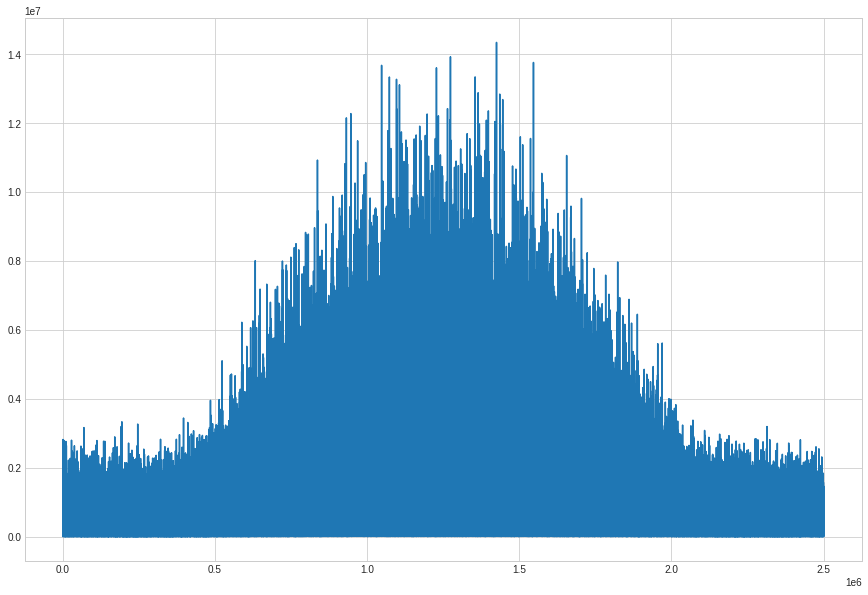

In [8]:
data = np.empty(data_cs16.shape[0]//2, dtype=np.complex64)
data.real = data_cs16[0::2]
data.imag = data_cs16[1::2]
data_t = np.arange(0, len(data)/fs, 1/fs)
plt.plot(np.absolute(spfft.fftshift(spfft.fft(data[:2500000]))));

# Do the acquisition
For this, you must know beforehand the visible SVs and their precise Doppler frequency.
This is just a rough (ctf-like) solution, so you can e.g. guess it with correlator tools like https://github.com/psas/gps (there are plenty of them on github, or write the tool yourself!) and adjust by hand to be able to recover the individual chirp phases during BPSK demodulation.
This section should be performed multiple times to have multiple data from different SVs and note the delays.

0.9952

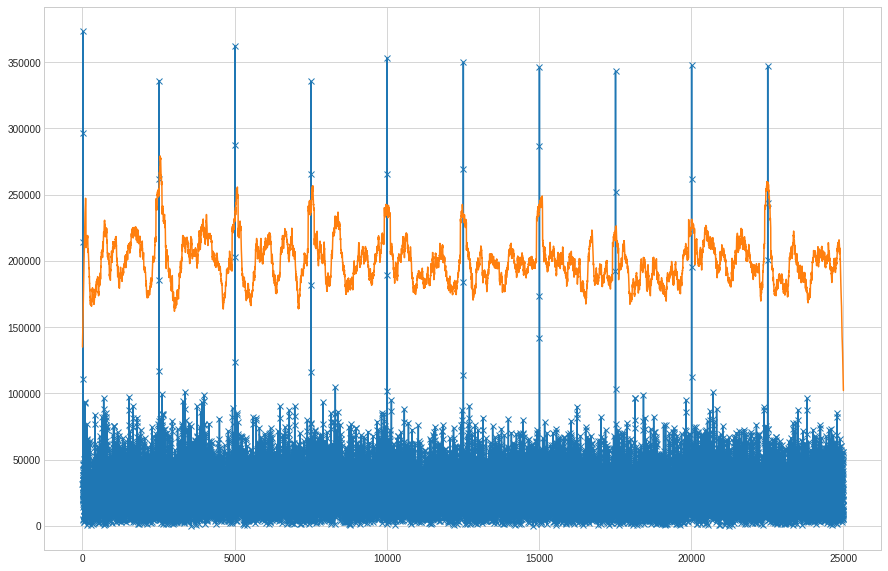

In [9]:
acq = Acquisition(data_cs16, fs)
#acq.correlate(12, -3429.1)
#acq.correlate(2, -3161.0)
#acq.correlate(5, 800.2)
acq.correlate(18, 2774.3)
#acq.correlate(21, 2284.6)
acq.plot_correlate()
acq.get_code_phase()

There are some nice peaks, the SV PRN must be corrent, and Doppler frequency should be in-range.

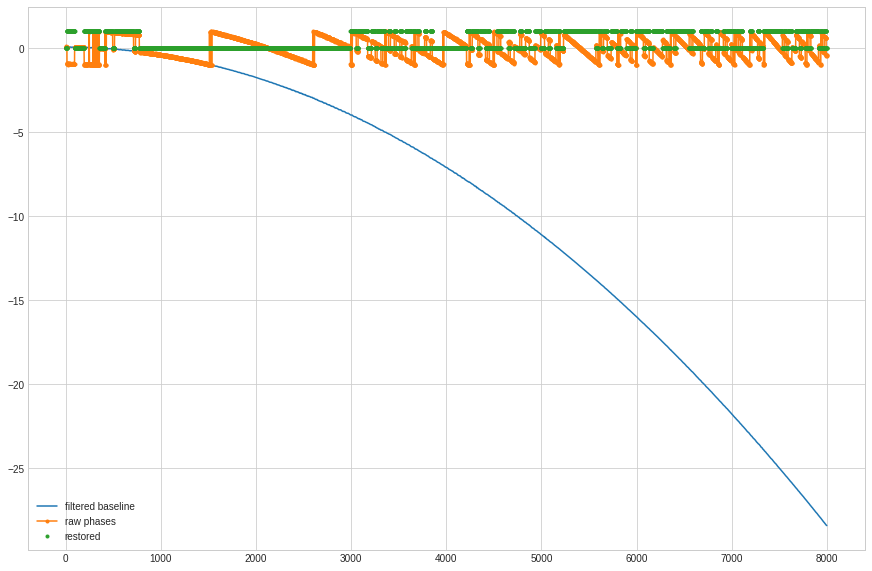

In [10]:
acq.find_peaks()
acq.demodulate(plot=True)

The unwrapped mean-phase is smooth and continuous, that's also a good sign! The Doppler-shift caused by SV motion can be corrected.

In [11]:
acq.get_bits()

'1000011111000000001110000100000000001001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110001000001100100101101101101100010101110110111111111111111111001000100010111101000010011101100111000110010001011000000000000000001001001100011000110110000100110000011010010000000101111010010110111010010101011110111011000000000010100110010010100001010'

In [12]:
acq.find_first_words(p=True)

217 100010111101000010011101100111000110010001011000000000000000
254 100010110000000000000000010010011000110001101100001001100000
342 1000101101010100001000100111111111101011001101101011110101


[{'bit_offset': 217, 'subframe_id': 0, 'tow': 77058},
 {'bit_offset': 254, 'subframe_id': 2, 'tow': 304446}]

There is a ToW (time of week) with 304446, which is roughly Thursday 12:34, exactly what we are looking for!

In [13]:
acq.get_sec()

12
12


[({'bit_offset': 217, 'subframe_id': 0, 'tow': 77058}, 77053.6679952),
 ({'bit_offset': 254, 'subframe_id': 2, 'tow': 304446}, 304440.92799520004)]

Now get the precise timestamp (at the moment of signal transmission from the SV) for the first sample of the stream. (Based on the filename we know that the first sample corresponds to the timestamp of 2020.05.06. 12:34:01)

In [14]:
# compute the SV position at t0 (suppose there's no local time offset!)
e = eph[18-1]

sv = SV(e)
tk = t0 - e["toc"]["sec"]
print("tk:", tk)

dst = (1000000, 1000000, 1000000) # dummy place for a starting point of iteration
dist = 20200000
for i in range(3):
    tprop = dist / 299792458.0
    print("tprop:", tprop)
    sv_pos, tcorr = sv.position_at_delta_t(tk - tprop)
    print("sv_pos tx frame:", sv_pos, "t_corr:", tcorr)
    sv_pos = sv.tx_to_rx_frame(sv_pos, tprop)
    print("sv_pos rx frame:", sv_pos)
    dist = sv.xyz_distance(sv_pos, dst)

tk: 2041.0
tprop: 0.06737994723002672
sv_pos tx frame: (25032062.170216456, 6900664.52943158, 5688358.068559062) t_corr: 0.00018079081018279152
sv_pos rx frame: (25032096.07580044, 6900541.536229822, 5688358.068559062)
tprop: 0.0840117270083709
sv_pos tx frame: (25032074.59536622, 6900661.62142538, 5688307.01119291) t_corr: 0.00018079080997184945
sv_pos rx frame: (25032116.869949635, 6900508.269002725, 5688307.01119291)
tprop: 0.0840117354923606
sv_pos tx frame: (25032074.595372554, 6900661.621423891, 5688307.01116688) t_corr: 0.00018079080997184934
sv_pos rx frame: (25032116.869960237, 6900508.268985749, 5688307.01116688)


So we know that out local time shows 12:34:01 (304441 tow), but our signal was transmitted at 304440.92799520004 (according to our previous calculation). Also the SV around that time has a time 0.00018079080997184934 sec correction coeffitient (relativistic effects).

And by combining those delays, we can guess the geometric distance between the observer and the given SV:

In [15]:
# recv time - send time + time correction SV
(t0-304440.92799520004+0.00018079080997184934)*299792458.0

21640695.690283086

We must collect multiple geometric distances from different SVs and solve it for the unknown location! For now, I just throw it to sympy to optimize instead of a proper (iterative) solution with linearized equations.

In [16]:
import sympy
from scipy.optimize import minimize
from sympy.utilities.lambdify import lambdify

Collect here the SV positions and the distances and hope for the best :)

In [17]:
# get some more data for other SVs and finally combine the observables into a solution:
x, y, z = sympy.symbols('x y z')

func = (
    (((x+10567809.462395392)**2 + (y-14123645.909694863)**2 + (z-20481039.054061014)**2) - 25125079.217653874**2)**2 + #02
    (((x+1516344.4764006932)**2 + (y-21430632.51922162)**2 + (z-15350786.814056003)**2) - 23475743.1794898**2)**2 + #05
    (((x-25032102.083775796)**2 + (y-6900531.92448324)**2 + (z-5688343.316786737)**2) - 21640695.689156935**2)**2 + #18
    (((x-25499726.646873526)**2 + (y-4725546.93050698)**2 + (z-5746677.798904001)**2) - 21648429.85190369**2)**2 + #21
    (((x-10290912.545586258)**2 + (y-24527745.429211177)**2 + (z-1395562.6552209333)**2) - 24225112.092427567**2)**2 #12
)

my_func = lambdify((x,y,z), func)
def my_func_v(x):
    return my_func(*tuple(x))

minimize(my_func_v, [1000000, 1000000, 1000000], method='Nelder-Mead',
         options={'maxiter': 20000, 'adaptive': True, 'disp': True})

 final_simplex: (array([[4149146.642621  , 1320606.9740837 , 4645583.70530268],
       [4149146.64262101, 1320606.9740837 , 4645583.70530268],
       [4149146.64262101, 1320606.9740837 , 4645583.70530268],
       [4149146.64262101, 1320606.9740837 , 4645583.70530268]]), array([8.27066769e+18, 8.27066769e+18, 8.27066769e+18, 8.27066769e+18]))
           fun: 8.270667685495803e+18
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 54835
           nit: 20000
        status: 2
       success: False
             x: array([4149146.642621  , 1320606.9740837 , 4645583.70530268])

Even though it didn't converged as fast as sympy wanted, the solution is pretty good!

In [18]:
np.array(sv.xyz_to_lla(4149146.642621  , 1320606.9740837 , 4645583.70530268))*(180/np.pi, 180/np.pi, 1)

array([ 47.04609464,  17.65544022, 444.85650404])

The location is very close to "Kab-hegy" (https://www.openstreetmap.org/search?query=47.04609464%2C%20%2017.65544022#map=16/47.0460/17.6567). As the description hinted the actual flag was hidden in Instagram posts featuring Carmen Sandiego herself, tagged with a few variations of locations and hashtags for "kabhegy" :D Jfyi, we chose this somewhat convoluted way to give a flag for calculating the right GPS coordinates to allow for some imprecision in the calculation to still give you a win. We were somewhat concerned that IG scraping would provide for a backdoor solution, but luckily insta privacy settings held up well. Phew :)

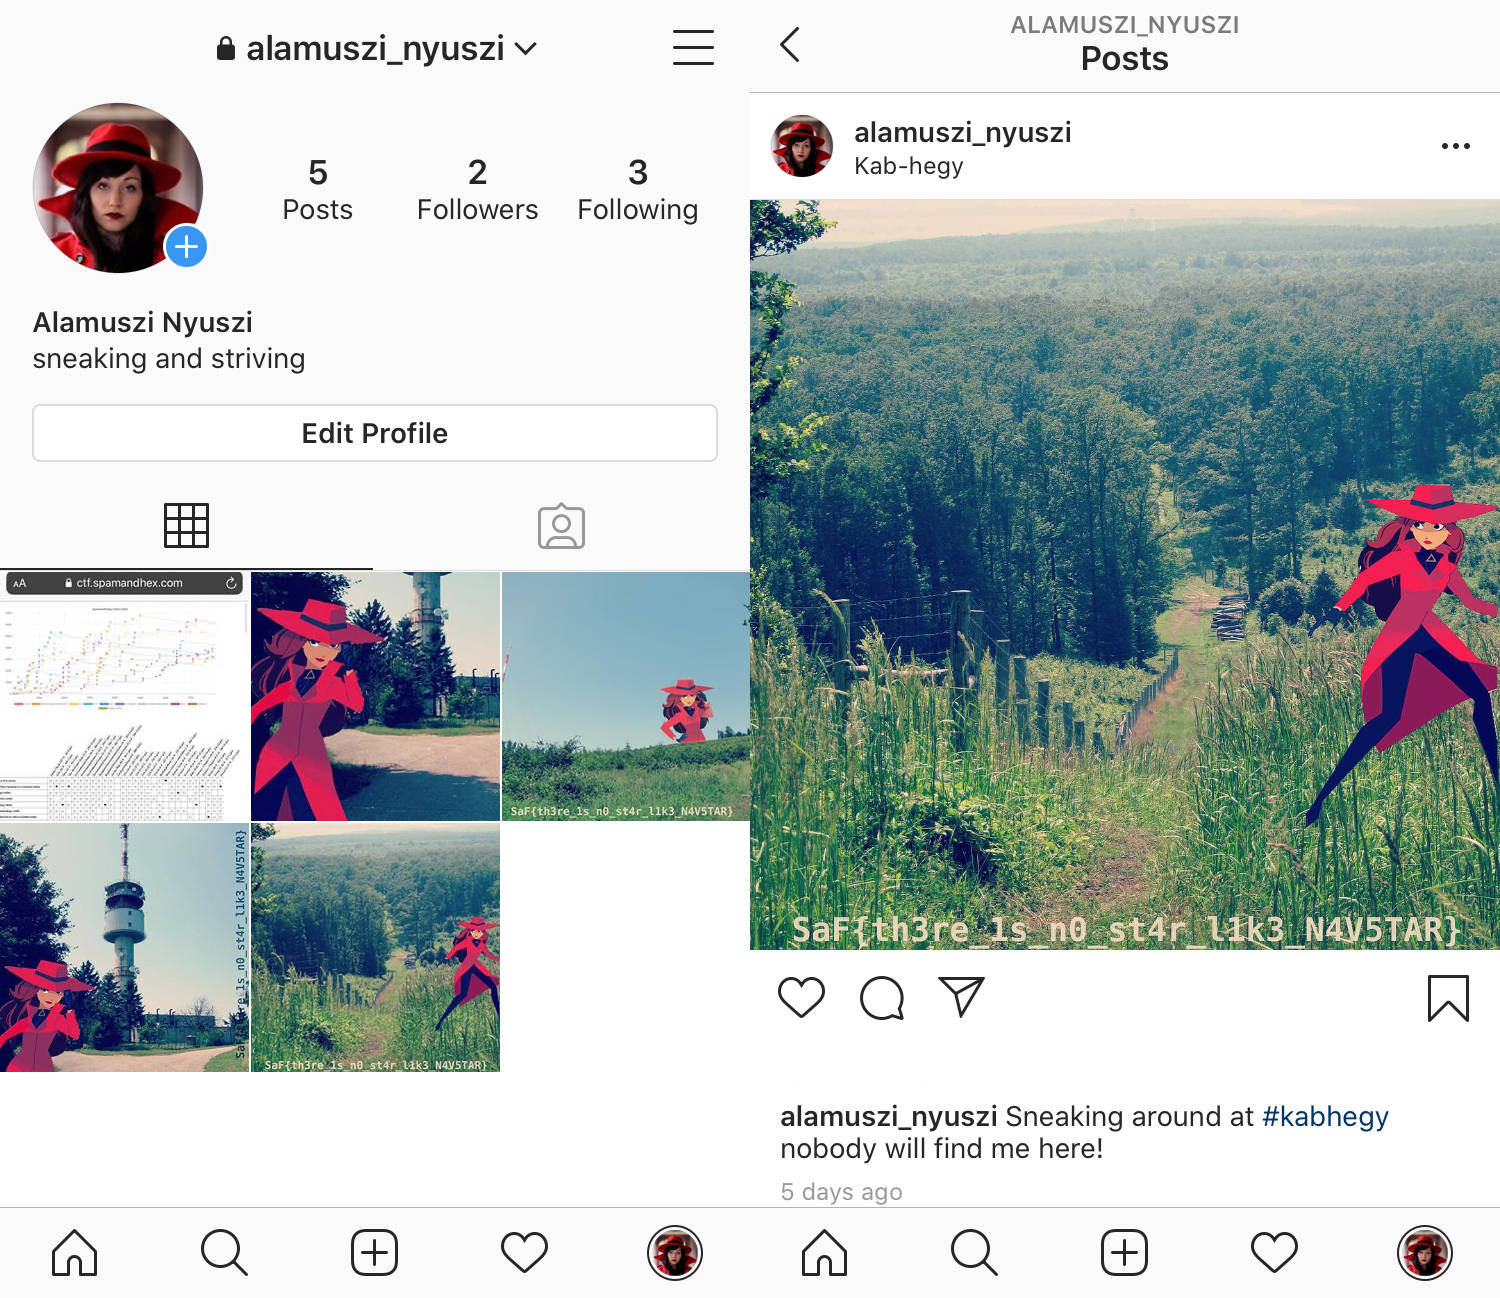

In [19]:
from IPython.display import Image
Image("instagram.jpg")